In [3]:
from pathlib import Path 
import pandas as pd
import re

BASE = Path.cwd()
P1 = BASE / "data_raw" / "mafi" / "mafi_2021_2024_01.xlsx"
P2 = BASE / "data_raw" / "mafi" / "mafi_2025_01.xlsx"

SYN = {  
    "idbanner": "id_estudiante",
    "tipoestudiante": "tipo_estudiante",
    "codprograma": "cod_programa",
    "plan": "plan_estudio",
}

PREFER = [
    "id_estudiante","cohorte","periodo","facultad","programa","cod_programa",
    "nivel","tipo_estudiante","sede","jornada","estrato","ingreso",
    "ruta_academica","plan_estudio","estado","estado_usuario","genero",
    "ciudad","codciudad","nacionalidad","fecha_nacimiento"
]

def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    cols = []
    for c in df.columns:
        c2 = str(c).strip().lower()
        c2 = re.sub(r"[^\w\s]", " ", c2)
        c2 = re.sub(r"\s+", "_", c2).strip("_")
        cols.append(c2)
    out = df.copy()
    out.columns = cols
    return out

def read_first_sheet(path: Path) -> pd.DataFrame:
    return pd.read_excel(path, engine="openpyxl", dtype=str)

def apply_synonyms(df: pd.DataFrame, syn: dict) -> pd.DataFrame:
    usable = {k: v for k, v in syn.items() if k in df.columns}
    return df.rename(columns=usable)

#Lectura
df1 = read_first_sheet(P1)
df2 = read_first_sheet(P2)

#Normaliza columnas + sinónimos
df1 = apply_synonyms(norm_cols(df1), SYN)
df2 = apply_synonyms(norm_cols(df2), SYN)

# Conteos antes del append
rows_df1 = len(df1)
rows_df2 = len(df2)
print("CONTEO PREVIO")
print(f"MAFI 2021-2024  : {rows_df1:,} observaciones")
print(f"MAFI 2025       : {rows_df2:,} observaciones")

#Columnas comunes y orden 
common = sorted(set(df1.columns) & set(df2.columns))
final_cols = [c for c in PREFER if c in common] + [c for c in common if c not in PREFER]

# Nombres de todas las columnas resultantes
print("\nCOLUMNAS RESULTANTES")
for c in final_cols:
    print(c)

#Append
mafi = pd.concat([df1[final_cols], df2[final_cols]], ignore_index=True)

#Casts 
for c in ("periodo","cohorte","estrato","codciudad"):
    if c in mafi.columns:
        mafi[c] = pd.to_numeric(mafi[c], errors="coerce").astype("Int64")
if "ingreso" in mafi.columns:
    mafi["ingreso"] = pd.to_numeric(mafi["ingreso"], errors="coerce")

#Duplicados
before = len(mafi)
mafi = mafi.drop_duplicates()
after = len(mafi)
dups = before - after

#Resumen 
print("\nRESUMEN APPEND MAFI")
print(f"Columnas comunes: {len(final_cols)}")
print(f"Filas antes de deduplicar: {before:,}")
print(f"Duplicados eliminados     : {dups:,}")
print(f"Filas finales             : {after:,}")



CONTEO PREVIO
MAFI 2021-2024  : 347,187 observaciones
MAFI 2025       : 127,159 observaciones

COLUMNAS RESULTANTES
id_estudiante
cohorte
periodo
facultad
programa
cod_programa
nivel
tipo_estudiante
sede
jornada
estrato
ingreso
ruta_academica
plan_estudio
estado
estado_usuario
genero
ciudad
codciudad
nacionalidad
fecha_nacimiento
atributos
autorizado_asistir
bloque
carga
cod_aprendizaje
cod_ruta
codigofacultad
codigonivel
codigotipoestudiante
comentarios
direccion
estado_civil
fecha_liq_iceberg
fecha_ret
fechaadmision
grupo_etnico
materias_inscritas
operador
ordenes_generadas
periodo_autorizado_asistir
saber11
sello
tipo_discapacidad
usuario
valor_liquidacion

RESUMEN APPEND MAFI
Columnas comunes: 46
Filas antes de deduplicar: 474,346
Duplicados eliminados     : 42
Filas finales             : 474,304


In [4]:
display(mafi.head(10))


,id_estudiante,cohorte,periodo,facultad,programa,cod_programa,nivel,tipo_estudiante,sede,jornada,...,grupo_etnico,materias_inscritas,operador,ordenes_generadas,periodo_autorizado_asistir,saber11,sello,tipo_discapacidad,usuario,valor_liquidacion
0,100158674,<NA>,202434,FAC CIENCIAS EMPRESARIALES,ADMINISTRACION DE EMPRESAS VIR,PAEV,PROFESIONAL,NO LEGALIZADO,VIR,VIRT,...,NO PERTENECE,NaN,CEI_BOGOTA,1,202434,AC201121067156,NO EXISTE,NINGUNA,nruizve1,0
1,100172954,<NA>,202441,FAC EDUCACION Y CCS HUM Y SOC,ESP DLLO INT INF ADOLES VIRTUA,EDIV,ESPECIALISTA,ADMITIDO NO MATRICULADO,VIR,VIRT,...,NaN,NaN,CEI_BOGOTA,1,NaN,NaN,NO EXISTE,NINGUNA,dgarc111,0
2,100120478,<NA>,202451,FAC EDUCACION Y CCS HUM Y SOC,MAESTRIA EN EDUCACION VIR,MED,MAESTRIA,ADMITIDO NO MATRICULADO,VIR,VIRT,...,NO INFORMA,NaN,FUNDACION YANAPAX,NaN,NaN,NaN,NO EXISTE,NINGUNA,lcabez10,NaN
3,100161522,<NA>,202431,FACULTAD DE INGENIERIA,INGENIERIA DE SOFTWARE VIRT,PISV,PROFESIONAL,ADMITIDO NO MATRICULADO,VIR,VIRT,...,NaN,NaN,FUNDECRED,1,NaN,AC201424871943,NO EXISTE,NINGUNA,avigapri,0
4,100153686,<NA>,202431,FACULTAD DE INGENIERIA,INGENIERIA DE SOFTWARE VIRT,PISV,PROFESIONAL,ADMITIDO NO MATRICULADO,VIR,VIRT,...,NO PERTENECE,NaN,SENA CONVENIO NACIONAL,1,NaN,AC201324315826,NO EXISTE,NINGUNA,myaravel,0
5,100152700,<NA>,202433,FACULTAD DE INGENIERIA,INGENIERIA INDUSTRIAL VIRT,PII,PROFESIONAL,NO LEGALIZADO,VIR,VIRT,...,NaN,NaN,SENA CONVENIO NACIONAL,NaN,NaN,AC201722271443,NO EXISTE,NINGUNA,ebarrio8,NaN
6,100080262,<NA>,202413,FAC EDUCACION Y CCS HUM Y SOC,PSICOLOGIA VIRTUAL,PPSV,PROFESIONAL,NO LEGALIZADO,VIR,VIRT,...,NO PERTENECE,NaN,CEI_BOGOTA,1,NaN,AC201421740968,NO EXISTE,NINGUNA,kramonfo,0
7,100187073,<NA>,202454,FAC EDUCACION Y CCS HUM Y SOC,MAESTRIA EN EDUCACION VIR,MED,MAESTRIA,ADMITIDO NO MATRICULADO,VIR,VIRT,...,NaN,NaN,FUNDECRED,1,202454,NaN,NO EXISTE,NINGUNA,eurangor,0
8,100182318,<NA>,202417,FACULTAD DE CCIAS HUMANAS SOCI,PSICOLOGIA VIRTUAL,PPSV,PROFESIONAL,NO LEGALIZADO,VIR,VIRT,...,NO PERTENECE,NaN,SENA CONVENIO NACIONAL,1,202417,AC201820573139,NO EXISTE,NINGUNA,jortizo4,0
9,100077508,<NA>,202153,FAC EDUCACION Y CCS HUM Y SOC,MAESTRIA EN EDUCACION VIR,MED,MAESTRIA,GRADUADO,VIR,VIRT,...,NO PERTENECE,NaN,FUNDACION YANAPAX,1,202153,NaN,NO EXISTE,NaN,oramoslo,0


,filas_totales,periodo_min,periodo_max,n_periodos_distintos,n_facultades,n_programas,n_niveles,n_tipos_estudiante,porc_faltante_ingreso
0,130663,202104,202556,144,10,190,6,28,0.01


,variable,n_no_nulos,porc_faltantes,cardinalidad,dtype
0,estrato,123580,5.42,7,Int64
1,facultad,130661,0.00,10,string
2,ingreso_cat,130655,0.01,7,category
3,nivel,130661,0.00,6,string
4,periodo,130661,0.00,144,Int64
5,programa,130661,0.00,190,string
6,tipo_estudiante,130661,0.00,28,string


Composición por tipo_estudiante (%)


,categoria,pct
0,ADMITIDO NO MATRICULADO,26.13
1,ESTUDIANTE ANTIGUO,19.47
2,NO LEGALIZADO,16.08
3,GRADUADO,13.59
4,PRIMER INGRESO,7.59
5,FINALIZO MATERIAS,3.17
6,ESTUDIANTE ANTIGUO (RECUPERO),2.79
7,SOLICITANTE CANCELACION SEMEST,2.15
8,PSEUDO ACTIVOS,2.04
9,TRANSFERENTE EXTERNO,2.0


Distribución por estrato (%)


,categoria,pct
0,2,44.55
1,1,32.13
2,3,20.36
3,4,2.42
4,5,0.39
5,6,0.14
6,0,0.01


Distribución por ingreso 1–7 (%)


,categoria,pct
0,4,28.37
1,1,26.09
2,5,18.17
3,3,13.98
4,2,11.30
5,6,1.73
6,7,0.36


Top facultades (%)


,categoria,pct
0,FAC EDUCACION Y CCS HUM Y SOC,35.1
1,FAC CIENCIAS EMPRESARIALES,21.52
2,FACULTAD DE CCIAS HUMANAS SOCI,17.47
3,FACULTAD DE INGENIERIA,15.85
4,FAC CIENCIAS DE LA SALUD,7.43
5,ESCUELA DE DERECHO,2.37
6,FACULTAD DE EDUCACIÓN,0.16
7,TODAS LAS FACULTADES,0.07
8,SIN FACULTAD ASIGNADA,0.03
9,MEDIO UNIVERSITARIO,0.01


Top programas (%)


,categoria,pct
0,PSICOLOGIA VIRTUAL,16.72
1,MAESTRIA EN EDUCACION VIR,12.86
2,LIC EN EDUCACION INFANTIL VIR,7.09
3,INGENIERIA INDUSTRIAL VIRT,6.44
4,ESP DLLO INT INF ADOLES VIRTUA,4.62
5,INGENIERIA DE SOFTWARE VIRT,4.54
6,CONTADURIA PUBLICA VIRTUAL,3.67
7,ESP GCIA SEG SALUD EN TRA VIRT,3.21
8,PSICOLOGIA,3.01
9,ADMINISTRACION DE EMPRESAS VIR,2.73


Distribución por periodo (%)


,categoria,pct
0,202534,14.1
1,202517,5.14
2,202555,4.44
3,202520,4.33
4,202531,2.8
...,...,...
139,202107,0.04
140,202105,0.03
141,202409,0.03
142,202509,0.01


Ingreso (1–7) por periodo — % por fila


ingreso_cat,1,2,3,4,5,6,7
periodo,,,,,,,
202104,100.0,0.0,0.0,0.0,0.0,0.0,0.0
202105,0.0,100.0,0.0,0.0,0.0,0.0,0.0
202106,0.0,0.0,100.0,0.0,0.0,0.0,0.0
202107,0.0,0.0,0.0,100.0,0.0,0.0,0.0
202108,0.0,0.0,0.0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...
202552,0.0,100.0,0.0,0.0,0.0,0.0,0.0
202553,0.0,0.0,100.0,0.0,0.0,0.0,0.0
202554,0.0,0.0,0.0,100.0,0.0,0.0,0.0


Tipo de estudiante por periodo — % por fila


tipo_estudiante,ADMITIDO NO MATRICULADO,ESTUDIANTE ANTIGUO,ESTUDIANTE ANTIGUO (ASISTENT),ESTUDIANTE ANTIGUO (PSEUDO EG),ESTUDIANTE ANTIGUO (RECUPERO),FALLECIDO,FINALIZO MATERIAS,GRADUADO,INGRESO SINGULAR (ASISTENTE),MOVILIDAD ENTRANTE,...,REINGRESO,RETIRADO,RETIRADO CON RESERVA DE CUPO,SANCIÓN ACADÉMICA,SOLICITANTE CANCELACION SEMEST,SUSPENDIDO POR PROC DISCIPLIN,TRANSFERENTE EXTERNO,TRANSFERENTE EXTERNO (ASISTEN),TRANSFERENTE EXTERNO PSEUD ING,TRANSFERENTE INTERNO
periodo,,,,,,,,,,,,,,,,,,,,,
202104,13.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00
202105,2.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00
202106,3.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00
202107,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,6.52,0.0,0.00,0.00,0.0,0.00
202108,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,1.43,0.0,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202552,98.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,1.49,0.0,0.00,0.00,0.0,0.00
202553,37.36,0.75,0.47,0.57,0.00,0.00,41.32,6.23,0.47,0.38,...,0.00,0.0,0.09,0.0,2.74,0.0,0.00,0.09,0.0,0.00
202554,60.88,6.15,0.00,0.00,0.32,0.00,0.32,0.00,2.37,0.00,...,0.00,0.0,1.26,0.0,1.89,0.0,0.00,1.89,0.0,1.89


Estrato por periodo — % por fila


estrato,0,1,2,3,4,5,6
periodo,,,,,,,
202104,0.0,6.25,26.56,53.12,9.38,1.56,3.12
202105,0.0,2.78,38.89,41.67,16.67,0.00,0.00
202106,0.0,5.66,26.42,45.28,15.09,5.66,1.89
202107,0.0,0.00,20.00,44.44,22.22,8.89,4.44
202108,0.0,4.35,21.74,43.48,24.64,2.90,2.90
...,...,...,...,...,...,...,...
202552,0.0,49.03,31.66,18.15,0.77,0.00,0.39
202553,0.0,46.64,33.79,17.29,2.08,0.10,0.10
202554,0.0,47.47,31.25,16.55,4.39,0.34,0.00


Nivel por periodo — % por fila


nivel,EDUCACION CONTINUA,ESPECIALISTA,MAESTRIA,PROFESIONAL,TECNICO,TECNOLOGICO
periodo,,,,,,
202104,100.00,0.0,0.00,0.0,0.0,0.0
202105,100.00,0.0,0.00,0.0,0.0,0.0
202106,100.00,0.0,0.00,0.0,0.0,0.0
202107,100.00,0.0,0.00,0.0,0.0,0.0
202108,100.00,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...
202552,0.00,0.0,100.00,0.0,0.0,0.0
202553,0.09,0.0,99.91,0.0,0.0,0.0
202554,0.00,0.0,100.00,0.0,0.0,0.0


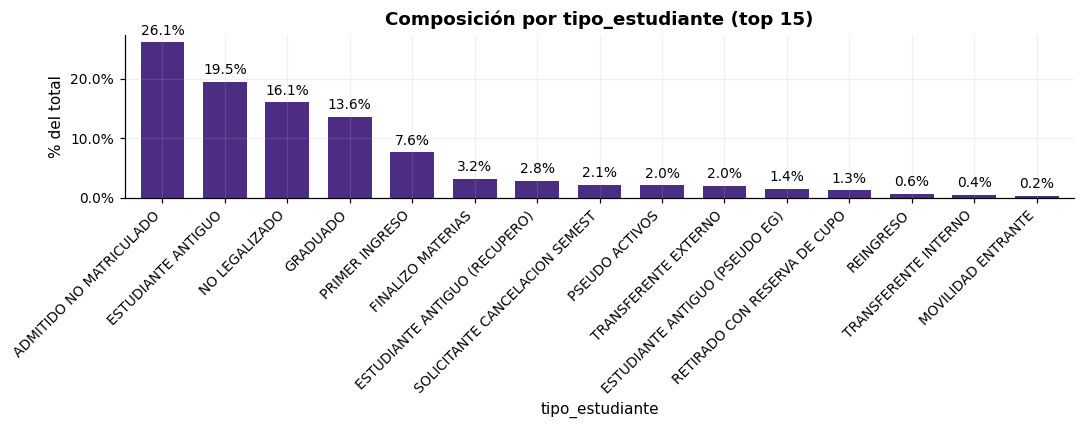

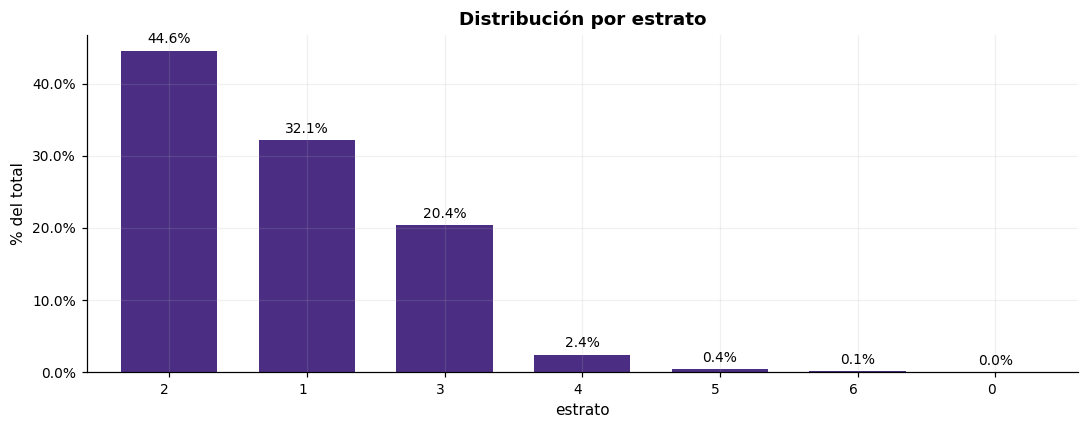

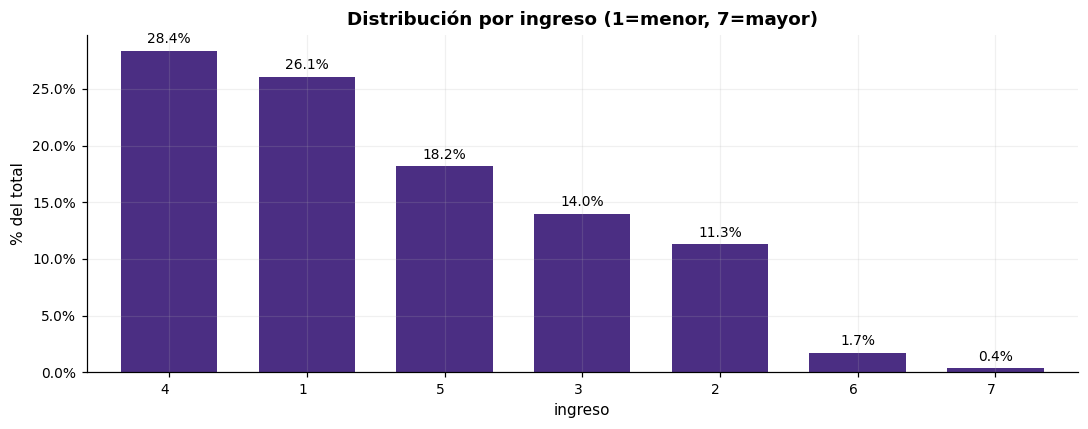

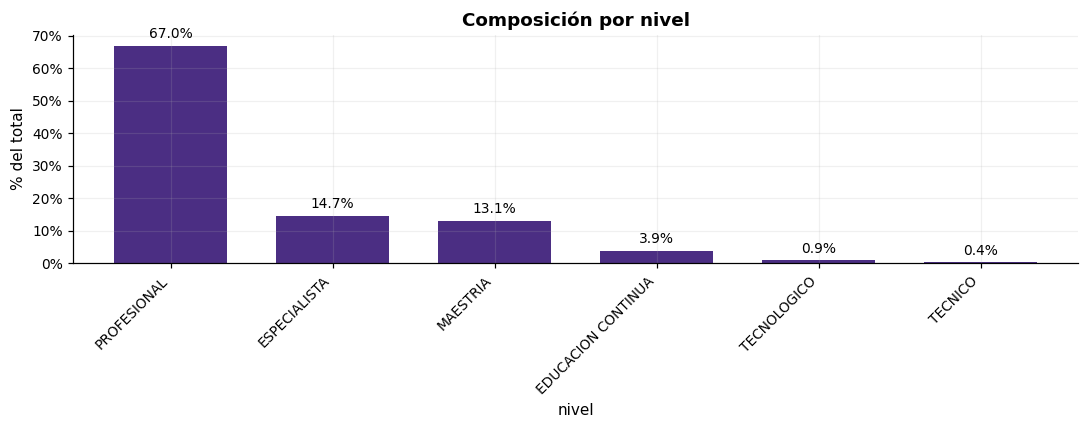

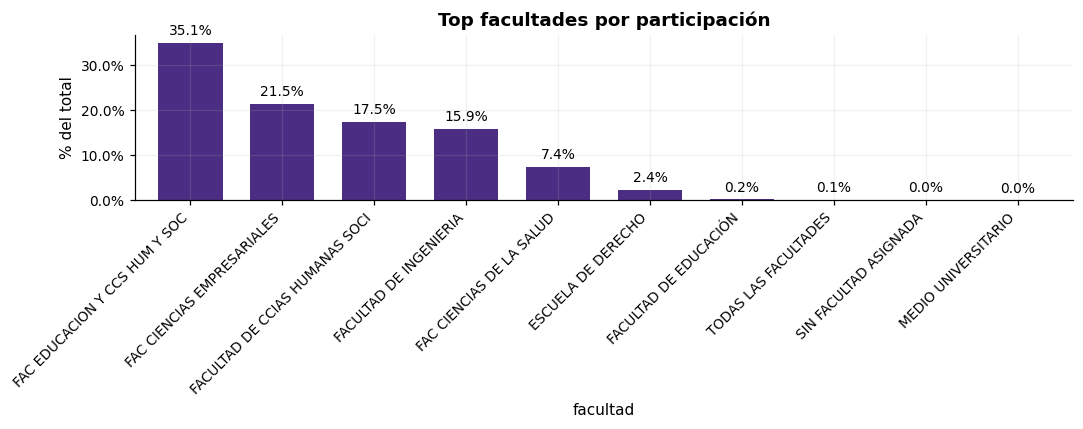

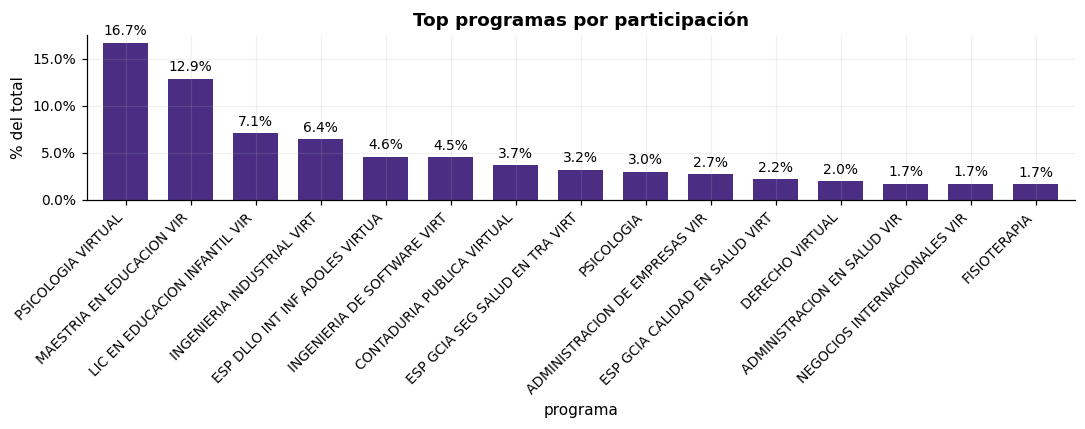

In [ ]:
# MAFI
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from cycler import cycler
from pathlib import Path

# Consolidación por alumno: conservar el registro del mayor periodo
# Asegura columna ID estándar
if "id_estudiante" not in mafi.columns:
    for alt in ["idbanner", "identificacion", "id"]:
        if alt in mafi.columns:
            mafi = mafi.rename(columns={alt: "id_estudiante"})
            break
assert "id_estudiante" in mafi.columns, "No se encuentra columna de identificación del estudiante"

# Tipificar periodo a entero 
mafi["periodo"] = pd.to_numeric(mafi.get("periodo"), errors="coerce").astype("Int64")

# Ordena por periodo y conserva el último por id_estudiante
mafi = (mafi
        .sort_values(["id_estudiante","periodo"])
        .drop_duplicates("id_estudiante", keep="last")
        .reset_index(drop=True))

# Estilo general
def set_viz():
    plt.rcParams.update({
        "figure.dpi": 110,
        "axes.spines.top": False, "axes.spines.right": False,
        "axes.grid": True, "grid.alpha": 0.18,
        "axes.titleweight": "bold", "axes.titlesize": 12,
        "axes.labelsize": 10, "xtick.labelsize": 9, "ytick.labelsize": 9,
        "legend.frameon": False, "legend.fontsize": 9,
    })
    plt.rcParams["axes.prop_cycle"] = cycler(color=[
        "#4B2E83","#005BBB","#7F56D9","#1F7A8C","#E67E22","#2D3748","#3BA99C"
    ])
set_viz()
ingreso_palette = {1:"#E6E6FA",2:"#C8B6FF",3:"#A78BFA",4:"#7C3AED",5:"#5B21B6",6:"#4338CA",7:"#1E3A8A"}

# Tipos mínimos y limpieza
for c in ("estrato",):
    if c in mafi.columns:
        mafi[c] = pd.to_numeric(mafi[c], errors="coerce").astype("Int64")

# ingreso como categórica ordinal 1–7
if "ingreso" in mafi.columns:
    ing_num = pd.to_numeric(mafi["ingreso"], errors="coerce").astype("Int64")
    ing_num = ing_num.where(ing_num.between(1,7), np.nan)
    mafi["ingreso_cat"] = pd.Categorical(ing_num, categories=[1,2,3,4,5,6,7], ordered=True)

# normaliza algunas categóricas de texto
for c in ["facultad","programa","nivel","tipo_estudiante","ciudad","sede","jornada",
          "plan_estudio","ruta_academica","estado","estado_usuario","nacionalidad"]:
    if c in mafi.columns:
        mafi[c] = mafi[c].astype("string").str.strip().str.replace(r"\s+"," ", regex=True)

# Tablas para el informe 
present = [c for c in ["periodo","facultad","programa","nivel","tipo_estudiante","estrato","ingreso_cat"] if c in mafi.columns]

# Resumen ejecutivo
tabla_ejecutiva = pd.DataFrame({
    "filas_totales":            [len(mafi)],
    "periodo_min":              [int(mafi["periodo"].min()) if "periodo" in present and mafi["periodo"].notna().any() else np.nan],
    "periodo_max":              [int(mafi["periodo"].max()) if "periodo" in present and mafi["periodo"].notna().any() else np.nan],
    "n_periodos_distintos":     [int(mafi["periodo"].nunique()) if "periodo" in present else np.nan],
    "n_facultades":             [int(mafi["facultad"].nunique()) if "facultad" in present else np.nan],
    "n_programas":              [int(mafi["programa"].nunique()) if "programa" in present else np.nan],
    "n_niveles":                [int(mafi["nivel"].nunique()) if "nivel" in present else np.nan],
    "n_tipos_estudiante":       [int(mafi["tipo_estudiante"].nunique()) if "tipo_estudiante" in present else np.nan],
    "porc_faltante_ingreso":    [round(mafi["ingreso_cat"].isna().mean()*100,2) if "ingreso_cat" in present else np.nan],
})
display(tabla_ejecutiva)

# Control de calidad
qc_vars = present
qc = pd.DataFrame({
    "variable": qc_vars,
    "n_no_nulos": [mafi[v].notna().sum() for v in qc_vars],
    "porc_faltantes": [round(mafi[v].isna().mean()*100,2) for v in qc_vars],
    "cardinalidad": [mafi[v].nunique(dropna=True) for v in qc_vars],
    "dtype": [str(mafi[v].dtype) for v in qc_vars],
}).sort_values("variable").reset_index(drop=True)
display(qc)

# Tablas de composición en %
def tabla_pct(series, top=None):
    s = series.dropna()
    if s.empty: return pd.DataFrame(columns=["categoria","pct"])
    t = (s.value_counts(normalize=True)*100).sort_values(ascending=False)
    if top: t = t.head(top)
    return t.round(2).rename_axis("categoria").reset_index(name="pct")

tbl_tipo = tabla_pct(mafi["tipo_estudiante"]) if "tipo_estudiante" in present else pd.DataFrame()
tbl_estr = tabla_pct(mafi["estrato"])         if "estrato"         in present else pd.DataFrame()
tbl_ing  = tabla_pct(mafi["ingreso_cat"])     if "ingreso_cat"     in present else pd.DataFrame()
tbl_fac  = tabla_pct(mafi["facultad"], top=10)if "facultad"        in present else pd.DataFrame()
tbl_prog = tabla_pct(mafi["programa"], top=15)if "programa"        in present else pd.DataFrame()
tbl_per  = tabla_pct(mafi["periodo"])         if "periodo"         in present else pd.DataFrame()

print("Composición por tipo_estudiante (%)"); display(tbl_tipo.head(15))
print("Distribución por estrato (%)");       display(tbl_estr)
print("Distribución por ingreso 1–7 (%)");   display(tbl_ing)
print("Top facultades (%)");                 display(tbl_fac)
print("Top programas (%)");                  display(tbl_prog.head(15))
print("Distribución por periodo (%)");       display(tbl_per)

# Crosstabs % 
def crosstab_pct(row, col, order_rows=None, order_cols=None, top_rows=None):
    x = mafi.dropna(subset=[row, col]).copy()
    if x.empty: return pd.DataFrame()
    if top_rows:
        order_rows = x[row].value_counts().head(top_rows).index.tolist()
    if order_rows is not None:
        x = x[x[row].isin(order_rows)]
    pv = pd.crosstab(x[row], x[col], normalize="index") * 100
    if order_cols is not None:
        pv = pv.reindex(columns=order_cols, fill_value=0)
    return pv.round(2)

xtb_ing_por_per   = crosstab_pct("periodo","ingreso_cat", order_cols=[1,2,3,4,5,6,7]) if {"periodo","ingreso_cat"}.issubset(present) else pd.DataFrame()
xtb_tipo_por_per  = crosstab_pct("periodo","tipo_estudiante")                          if {"periodo","tipo_estudiante"}.issubset(present) else pd.DataFrame()
xtb_estr_por_per  = crosstab_pct("periodo","estrato")                                  if {"periodo","estrato"}.issubset(present) else pd.DataFrame()
xtb_nivel_por_per = crosstab_pct("periodo","nivel")                                    if {"periodo","nivel"}.issubset(present) else pd.DataFrame()

print("Ingreso (1–7) por periodo — % por fila");        display(xtb_ing_por_per)
print("Tipo de estudiante por periodo — % por fila");   display(xtb_tipo_por_per)
print("Estrato por periodo — % por fila");              display(xtb_estr_por_per)
print("Nivel por periodo — % por fila");                display(xtb_nivel_por_per)

# Gráficos
def _annotate(ax):
    for p in ax.patches:
        h = p.get_height()
        if np.isnan(h) or h == 0: continue
        ax.annotate(f"{h:.1f}%", (p.get_x()+p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=9, xytext=(0,3), textcoords="offset points")

def bar_pct_plot(series, title, xlabel, top=None, rot=45, width=0.7):
    s = series.dropna()
    if s.empty:
        print(f"(sin datos para {title})"); 
        return
    pct = (s.value_counts(normalize=True)*100).sort_values(ascending=(series.name=="periodo"))
    if series.name == "periodo":
        pct = (s.value_counts(normalize=True).sort_index()*100)
    if top: pct = pct.head(top)
    fig, ax = plt.subplots(figsize=(10,4))
    pct.plot(kind="bar", ax=ax, width=width)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel("% del total")
    ax.yaxis.set_major_formatter(PercentFormatter(100))
    _annotate(ax); plt.xticks(rotation=45 if series.name=="periodo" else rot, ha="right"); plt.tight_layout(); plt.show()

def stacked_pct_plot(df, row, col, title, xlabel, order_rows=None, order_cols=None, top_rows=None, rot=0):
    pv = crosstab_pct(row, col, order_rows=order_rows, order_cols=order_cols, top_rows=top_rows)
    if pv.empty:
        print(f"(sin datos para {title})"); return
    if row == "periodo":
        pv = pv.sort_index()
    fig, ax = plt.subplots(figsize=(11,4))
    left = np.zeros(len(pv))
    for c in pv.columns:
        vals = pv[c].values
        ax.bar(pv.index.astype(str), vals, bottom=left, label=str(c),
               color=ingreso_palette.get(c, None), edgecolor="white", linewidth=0.4)
        left += vals
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel("% dentro de categoría")
    ax.yaxis.set_major_formatter(PercentFormatter(100))
    ax.legend(title=col, ncols=min(len(pv.columns), 8), bbox_to_anchor=(1.02,1), loc="upper left")
    plt.xticks(rotation=45 if row=="periodo" else rot, ha="right"); plt.tight_layout(); plt.show()

# Barras en % con etiquetas
if "tipo_estudiante" in present: bar_pct_plot(mafi["tipo_estudiante"], "Composición por tipo_estudiante (top 15)", "tipo_estudiante", top=15)
if "estrato" in present:          bar_pct_plot(mafi["estrato"].astype("Int64"), "Distribución por estrato", "estrato", rot=0)
if "ingreso_cat" in present:      bar_pct_plot(mafi["ingreso_cat"], "Distribución por ingreso (1=menor, 7=mayor)", "ingreso", rot=0)
if "nivel" in present:            bar_pct_plot(mafi["nivel"], "Composición por nivel", "nivel")
if "facultad" in present:         bar_pct_plot(mafi["facultad"], "Top facultades por participación", "facultad", top=10)
if "programa" in present:         bar_pct_plot(mafi["programa"], "Top programas por participación", "programa", top=15)
